In [35]:
#importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,RobustScaler,MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,validation_curve,GridSearchCV,learning_curve
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score,accuracy_score


In [2]:
def charger_fichier(path):
    ext = path.split(".")[-1]
    if ext in ['csv','txt']:
        data = pd.read_csv(path)
    elif ext in ['xls','xlsx']:
        data = pd.read_excel(path)
    return data

In [3]:
def normalisation(df, method):
    """
    Méthode permettant de normaliser les données quantitatives d'un dataframe
    @params df : Dataframe
    @params method: Entier compris entre 1 et 3
        1 => Utilisation de MinMax
        2 => Utilisation de Z-score
        3 => Utilisation de la méthode robuste (résiste aux valeurs aberrantes)
    """
    df_copy = df.copy()  # Utiliser une copie du DataFrame pour éviter de modifier l'original
    
    if method == 1:
        scaler = MinMaxScaler()
    elif method == 2:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    scaled_data = scaler.fit_transform(df_copy.select_dtypes(include=['int', 'float']))
    df_copy.loc[:, df_copy.select_dtypes(include=['int', 'float']).columns] = scaled_data
    return df_copy

# Exploration des données

In [4]:
df = charger_fichier('donnees_generer_complet_consultations_medicales.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age (en mois)         1004 non-null   float64
 1   Sexe                  1004 non-null   object 
 2   Poids (kg)            1004 non-null   float64
 3   Symptômes             1004 non-null   object 
 4   Antécédents medicaux  1004 non-null   object 
 5   Pathologie            1004 non-null   object 
 6   Traitement            1004 non-null   object 
dtypes: float64(2), object(5)
memory usage: 55.0+ KB


In [6]:
df.head()

,Age (en mois),Sexe,Poids (kg),Symptômes,Antécédents medicaux,Pathologie,Traitement
0,420.0,M,80.0,"Tremblements, Sueurs, Anxiété",Aucun,Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
1,504.0,F,68.0,"Confusion, Convulsions",Diabète de type 2,Hypoglycémie sévère,Administrer 1 ml/ de glucose 50% en IV lente (...
2,600.0,M,95.0,"Tremblements, Pâleur",Aucun,Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
3,336.0,F,60.0,"Fatigue, Léthargie",Aucun,Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
4,540.0,M,92.0,"Confusion, Coma",Diabète de type 1,Hypoglycémie sévère,Administrer 1 ml/ de glucose à 50% en IV lente...


In [7]:
df.describe(include='all')

,Age (en mois),Sexe,Poids (kg),Symptômes,Antécédents medicaux,Pathologie,Traitement
count,1004.000000,1004,1004.000000,1004,1004,1004,1004
unique,NaN,2,NaN,258,23,61,162
top,NaN,F,NaN,"Plaques cutanées, diarrhée, démence",Aucun,Paludisme,prescrire une association de 4 antituberculeux...
freq,NaN,510,NaN,40,933,70,40
mean,307.189442,NaN,48.138546,NaN,NaN,NaN,NaN
std,225.148615,NaN,25.560345,NaN,NaN,NaN,NaN
min,2.000000,NaN,3.500000,NaN,NaN,NaN,NaN
25%,84.000000,NaN,22.000000,NaN,NaN,NaN,NaN
50%,324.000000,NaN,56.000000,NaN,NaN,NaN,NaN
75%,468.000000,NaN,70.000000,NaN,NaN,NaN,NaN


In [8]:
df.isnull().sum()

Age (en mois)           0
Sexe                    0
Poids (kg)              0
Symptômes               0
Antécédents medicaux    0
Pathologie              0
Traitement              0
dtype: int64

# Transformation de la colonne Symptomes en 05 autres colonnes

In [9]:
symptomes = df['Symptômes']

# Diviser les symptômes en colonnes individuelles
for i, symptome in enumerate(symptomes):
    if isinstance(symptome, str):  # Vérifier si la valeur est une chaîne de caractères
        tabs = symptome.split(',')
        for j, tab in enumerate(tabs[:5]):
            df.at[i, f'Symptome_{j + 1}'] = tab.strip()

# Supprimer la colonne "Symptômes" originale
df = df.drop(columns=['Symptômes'])


In [10]:
# Sélectionnez les 5 dernières colonnes
dernieres_colonnes = df.iloc[:, -5:]

# Supprimez les 5 dernières colonnes du DataFrame original
df = df.iloc[:, :-5]

# Insérez les 5 dernières colonnes à la 3e position
position_inserer = 3  # L'index 2 correspond à la 3e position (index de base 0)
for col in dernieres_colonnes.columns:
    df.insert(position_inserer, col, dernieres_colonnes[col])



In [11]:
#Modalités de la variable cible
df.loc[:, 'Pathologie'].unique()

array(['Hypoglycémie', 'Hypoglycémie sévère', 'Grippe', 'Myalgie',
       'Bronchite', 'Dermatite', 'Gastroentérite',
       'Angine streptococcique', 'Pyélonéphrite', 'Migraine',
       'Ulcère gastrique', 'Infection urinaire', 'Bronchite chronique',
       'Otite externe', 'Arthrite rhumatoïde', 'Colite',
       'Reflux gastro-œsophagien', 'Colique abdominale', 'Anémie',
       'Amaigrissement', 'Obstruction Sévère', 'Obstruction Légère',
       'Obstruction Complète Imminente', 'Obstruction Modérée',
       'Rhinopharyngite', 'Rhinite', 'Sinusite bactérienne',
       'Sinusite virale', 'Angine érythémateuse (virale)',
       'Angine bactérienne', 'Angine vésiculeuse (virale)',
       'Angine ulcéro-nécrotique (bactérienne)',
       'Angine pseudo-membraneuse (bactérienne)',
       'Angine érythémateuse (bactérienne)', 'Angine virale',
       'Angine ulcéro-nécrotique (virale)', 'Bronchite aiguë',
       'Trachéite bactérienne', 'Otite externe aiguë',
       'Otite moyenne aiguë (OMA

# Suppresion des colonnes inutiles

In [12]:
useless_cols = ['Traitement']
df.drop(useless_cols,axis=1,inplace=True)
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Antécédents medicaux,Pathologie
0,420.0,M,80.0,NaN,NaN,Anxiété,Sueurs,Tremblements,Aucun,Hypoglycémie
1,504.0,F,68.0,NaN,NaN,NaN,Convulsions,Confusion,Diabète de type 2,Hypoglycémie sévère
2,600.0,M,95.0,NaN,NaN,NaN,Pâleur,Tremblements,Aucun,Hypoglycémie
3,336.0,F,60.0,NaN,NaN,NaN,Léthargie,Fatigue,Aucun,Hypoglycémie
4,540.0,M,92.0,NaN,NaN,NaN,Coma,Confusion,Diabète de type 1,Hypoglycémie sévère


## Comprehension des donnees

In [37]:
cols_ = df.select_dtypes(include=['object']).columns
for var in cols_:
    df[var].value_counts().plot(kind='pie',autopct='%1.1f%%')
    plt.title(var)
    plt.axis('equal')
    plt.show()

# Normalisation 

In [14]:

df_normalized = normalisation(df, method=1)
# Remplacement des colonnes normalisées dans le DataFrame original
df = df_normalized

# Afficher le DataFrame après normalisation
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Antécédents medicaux,Pathologie
0,0.436326,M,0.827027,NaN,NaN,Anxiété,Sueurs,Tremblements,Aucun,Hypoglycémie
1,0.524008,F,0.697297,NaN,NaN,NaN,Convulsions,Confusion,Diabète de type 2,Hypoglycémie sévère
2,0.624217,M,0.989189,NaN,NaN,NaN,Pâleur,Tremblements,Aucun,Hypoglycémie
3,0.348643,F,0.610811,NaN,NaN,NaN,Léthargie,Fatigue,Aucun,Hypoglycémie
4,0.561587,M,0.956757,NaN,NaN,NaN,Coma,Confusion,Diabète de type 1,Hypoglycémie sévère


# Encodage des variables qualitatives

In [15]:
encoder_symptome_5 = LabelBinarizer()
encoder_symptome_4 = LabelBinarizer()
encoder_symptome_3 = LabelBinarizer()
encoder_symptome_2 = LabelBinarizer()
encoder_symptome_1 = LabelBinarizer()
encoder_sexe = LabelBinarizer()
encoder_antecedents_medicaux = LabelBinarizer()
encoder_pathologie = LabelEncoder()


In [16]:
def encodage(data, columns, cible):
    
    #Encodage des variables explicatives qualitative avec LabelBinarizer
    cat_col = list(_ for _ in columns)
    for col in cat_col:
        enc_data = None  # Initialisation de enc_data
        if col == "Symptome_5":
            enc_data = encoder_symptome_5.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_4":
            enc_data = encoder_symptome_4.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_3":
            enc_data = encoder_symptome_3.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_2":
            enc_data = encoder_symptome_2.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_1":
            enc_data = encoder_symptome_1.fit_transform(data.loc[:, col].astype(str))
        elif col == "Antécédents medicaux":
            enc_data = encoder_antecedents_medicaux.fit_transform(data.loc[:, col].astype(str))
        elif col == "Sexe":
            enc_data = encoder_sexe.fit_transform(data.loc[:, col].astype(str))

        if enc_data is not None:
            prev_mod = [f"{col}_{mod}" for mod in list(data.loc[:, col].unique())]
            if len(prev_mod) == enc_data.shape[1]:
                data[prev_mod] = enc_data
                data.drop(col, axis=1, inplace=True)
            else:
                data.drop(col, axis=1, inplace=True)
                data[col] = enc_data
            
    #Encodage de la variable cible avec LabelEncoder
    enc_cible = encoder_pathologie.fit_transform(data.loc[:,cible])
    data.drop(cible,axis=1,inplace=True)
    data[cible] = enc_cible
            
    return data
                                            

In [17]:
#Liste des variables categorielles a encoder
cols_to_encoder = df.select_dtypes(include=['object']).columns
cols_to_encoder

Index(['Sexe', 'Symptome_5', 'Symptome_4', 'Symptome_3', 'Symptome_2',
       'Symptome_1', 'Antécédents medicaux', 'Pathologie'],
      dtype='object')

In [18]:
df=encodage(df,cols_to_encoder,'Pathologie')

/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_21380/3471138655.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_21380/3471138655.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_21380/3471138655.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [19]:
# Exportez les données traitées vers un fichier CSV
df.to_csv('donnees_traites.csv', index=False)


In [20]:
prepared_data = charger_fichier('donnees_traites.csv')

In [21]:
prepared_data.shape

(1004, 290)

## Nombres de pathologies présentent

In [22]:
len(prepared_data.loc[:, 'Pathologie'].unique())

61

# Separation des donnees en Train et Test

In [23]:
y = prepared_data['Pathologie']
X = prepared_data.drop('Pathologie',axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [25]:
X_train.shape

(803, 289)

In [26]:
X_test.shape


(201, 289)

## Recherche du meilleur estimateur avec ses parametres avec GridSearchCv

In [27]:
models = parametres_grid = [
    ('K-Nearest Neighbors (KNN)', KNeighborsClassifier(), {
        "n_neighbors": np.arange(1, 20),
        "metric": ["euclidean", "manhattan"],
        "weights": ["uniform", "distance"]
    }),

    ('Decision Tree', DecisionTreeClassifier(), {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None, 2, 4, 6, 8, 10],
        "min_samples_split": np.arange(2, 10, 1),
        "min_samples_leaf": list(range(1, 10, 1))
    }),

    ('Random Forest', RandomForestClassifier(), {
        "criterion": ["gini", "entropy"],
        "n_estimators": [50, 100, 150],
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [None, 1, 3, 5, 7, 9]
    }),

    ('Bagging', BaggingClassifier(), {
        "n_estimators": [10, 20, 30],
        "max_samples": np.arange(0.1, 1.1, 0.1),
        "max_features": np.arange(0.1, 1.1, 0.1)
    }),

    ('Logistic Regression', LogisticRegression(max_iter=10000, multi_class='multinomial'), {
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2"],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }),

    ('Naive Bayes', MultinomialNB(), { 
        "alpha": [0.1, 0.5, 1.0], 
        "fit_prior": [True, False]  
    }),

]


model_names = []
best_parametre = []
score = []
bons_model  = []
# Boucle pour tester chaque modèle avec GridSearchCV
for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5,n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_score = grid_search.score(X_test, y_test)
    # print(f"Meilleurs paramètres pour {model_name} :")
    # print(grid_search.best_params_)
    # print("Score de validation croisée :", grid_search.best_score_)
    # print("\n")
    score.append(grid_score)
    model_names.append(model_name)
    best_parametre.append(grid_search.best_params_)
    bons_model.append(grid_search)
    
model_search = pd.DataFrame({"Algorithme": model_names, "Meilleur parametres": best_parametre, "score" : score, "model_al" : bons_model})

/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/maestro/anacon

In [28]:
model_search.sort_values(by='score', ascending=False)

,Algorithme,Meilleur parametres,score,model_al
4,Logistic Regression,"{'C': 100.0, 'penalty': 'l2', 'solver': 'sag'}",0.935323,"GridSearchCV(cv=5,\n estimator=Log..."
2,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.925373,"GridSearchCV(cv=5, estimator=RandomForestClass..."
0,K-Nearest Neighbors (KNN),"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.920398,"GridSearchCV(cv=5, estimator=KNeighborsClassif..."
5,Naive Bayes,"{'alpha': 0.1, 'fit_prior': False}",0.915423,"GridSearchCV(cv=5, estimator=MultinomialNB(), ..."
3,Bagging,"{'max_features': 0.6, 'max_samples': 1.0, 'n_e...",0.875622,"GridSearchCV(cv=5, estimator=BaggingClassifier..."
1,Decision Tree,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.850746,"GridSearchCV(cv=5, estimator=DecisionTreeClass..."


In [29]:
model= model_search['model_al'][4]
model

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000,
                                          multi_class='multinomial'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [30]:
model.score(X_test,y_test)

0.9353233830845771

## Matrice de confusion

In [31]:
confusion_matrix(y_test,model.predict(X_test))

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  7,  0,  0],
       [ 0,  0,  0, ...,  0, 13,  0],
       [ 0,  0,  0, ...,  0,  0,  5]])

In [32]:
print("Score d'entraitenant : ",model.score(X_train,y_train))
print("Score de test : ",model.score(X_test,y_test))

Score d'entraitenant :  0.9962640099626401
Score de test :  0.9353233830845771


## Courbe de validation

/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

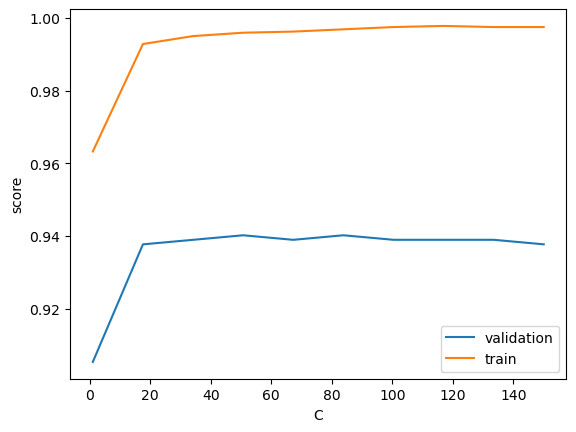

In [33]:

k= np.linspace(1,150,10)
train_score, val_score = validation_curve(LogisticRegression(),X_train,y_train,param_name='C',param_range=k,cv=5)
plt.plot(k,val_score.mean(axis=1),label='validation')
plt.plot(k,train_score.mean(axis=1),label='train')

plt.xlabel('C')
plt.ylabel('score')
plt.legend()

## Courbe d'apprentissage

In [34]:
N,train_score, val_score = learning_curve(model,X_train,y_train,train_sizes = np.linspace(0.2,1.0,10),cv=5)
print(N)

/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plt.plot(N,val_score.mean(axis=1),label='learning')
plt.plot(N,train_score.mean(axis=1),label='train')

plt.xlabel('C')
plt.ylabel('score')
plt.legend()